In [114]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA
from jaxopt import BoxOSQP

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [164]:
n = 10
m = 20
num_itr = 25
K = 200
adam_lr = 3e-3
max_inner = 40

rng = jax.random.PRNGKey(42)
rng, subkey = jax.random.split(rng, num=2)

A = np.random.randn(m,n)
Pinv = LA.pinv(A)
eig, _ = LA.eig(A.T @ A)
lambda_max = max(eig)
eta_opt = 1/lambda_max
A = jnp.array(A)

# jaxに内蔵されたOSQPの使い方メモ
二次計画問題の一般化式

$
\min \frac{1}{2}x^TQx+c^{T}x
$

$
st. Ax = z, l \leq z \leq u
$
に当てはめたときのQ, c, A, l, uを引数として与えて最適解を得る事ができる

今回は等式制約はないので、BoxCDQPというのを使っても解ける

👉[参考](https://jaxopt.github.io/stable/quadratic_programming.html#box-constrained-qps-with-equality)

In [166]:
def get_opt(Q, c, A, l, u):
    qp = BoxOSQP()
    sol = qp.run(params_obj=(Q, c), params_eq=A, params_ineq=(l, u)).params
    return sol.primal[0] #双対な解のうちのひとつ

In [167]:
@jax.jit
def gen_x_opt(y):
    x_opt = get_opt(A.T@A, -y@A, jnp.eye(n), -jnp.ones(n), jnp.ones(n))
    return x_opt
batch_gen_x_opt = jax.vmap(gen_x_opt, in_axes=[-1], out_axes=-1)

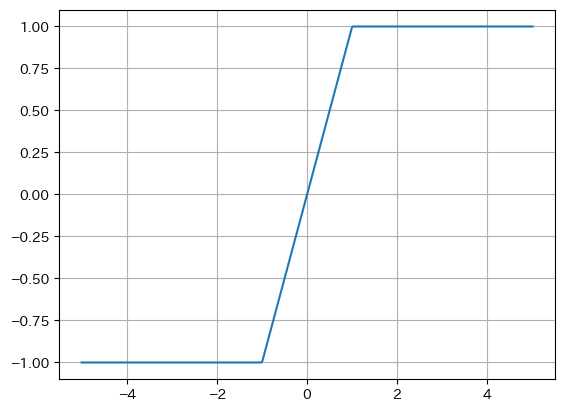

In [168]:
xs = jnp.linspace(-5, 5, 500)
plt.plot(xs, jax.nn.hard_tanh(xs))
plt.grid()

In [169]:
def ProjectedGD(max_itr, y):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= eta_opt * A.T @ (A@x - y)
        x = jax.nn.hard_tanh(x)
    return x

def comp_mse(max_itr):
    y = np.random.randn(m, K)
    x_opt = batch_gen_x_opt(y)
    x_hat = ProjectedGD(max_itr, y)
    return jnp.sum(batch_get_dot(x_opt - x_hat))/K

In [172]:
df = pd.DataFrame()
df["Iteration"] = range(num_itr)
df["PGD (fixed step size)"] = [float(comp_mse(i)) for i in range(num_itr)]

In [173]:
def DU_ProjectedGD(max_itr, y, eta):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= eta[i] * A.T @ (A@x - y)
        x = jax.nn.hard_tanh(x)
    return x

In [174]:
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

def loss(x_opt, max_itr, y, eta):
    x_hat = DU_ProjectedGD(max_itr, y, eta)
    return np.sum(batch_get_dot(x_opt - x_hat))/K

In [175]:
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(x_opt, max_itr, y, step_num, opt_state):
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_opt, max_itr, y, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

# @jax.jit
def train(eta):
    opt_state = opt_init(eta)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            y = np.random.randn(m, K)
            x_opt = jnp.array(batch_gen_x_opt(y))
            value, opt_state = step(x_opt, itr+1, y, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [176]:
eta_init = jnp.zeros(num_itr)
eta_trained = train(eta_init)

  0%|          | 0/25 [00:00<?, ?it/s]

loss:2.935562726236185e-08  

In [177]:
def comp_mse_DUPGD(max_itr, eta):
    y = np.random.randn(m, K)
    x_opt = jnp.array(batch_gen_x_opt(y))
    return loss(x_opt, max_itr, y, eta)

In [178]:
DUPGD_mse = [comp_mse_DUPGD(i+1, eta_trained) for i in range(num_itr)]
df["DU-PGD"] = np.array(DUPGD_mse)
df["opt_param"] = np.array(eta_trained)

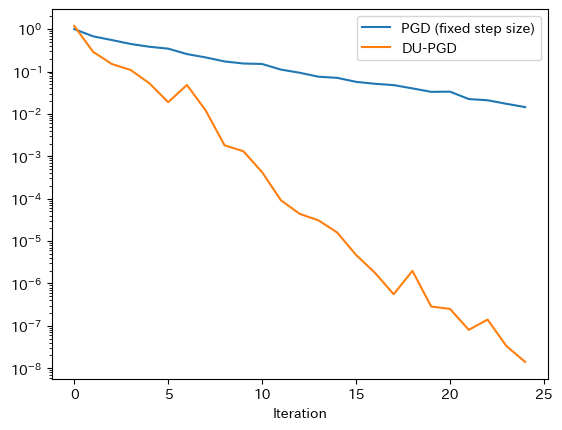

In [179]:
df.plot("Iteration", ["PGD (fixed step size)","DU-PGD"])
plt.yscale("log")

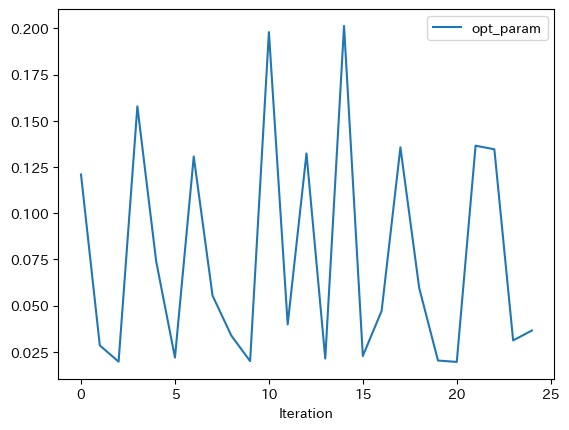

In [180]:
df.plot("Iteration", "opt_param");